In [0]:
dbutils.widgets.text("Turbine", "4704")

# Important notes
- Interchange X and Y.
- Remove duplicates from predictions (currently done by hand).
- Currently only My is considered.

# Calculation of consumed life from loads acc. to DIN EN 1993-1-9

- An eccentricity stress concentration factor of 1.0 (ie. no eccentricity) is assumed.
- A conservative Wöhler slope of \\(m=4\\) is assumed.
- A safety factor \\(\gamma_R\\) of 1.15 on resistance is applied.

## Importing packages and installing dependencies

In [0]:
%pip install seaborn
%pip install soerp
%pip install mcerp
%pip install pandas
%pip install xlrd
%pip install openpyxl
%pip install scipy

Python interpreter will be restarted.
Requirement already satisfied: seaborn in /databricks/python3/lib/python3.8/site-packages (0.10.0)
Requirement already satisfied: scipy>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (1.5.2)
Requirement already satisfied: numpy>=1.13.3 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (1.19.2)
Requirement already satisfied: matplotlib>=2.1.2 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (3.2.2)
Requirement already satisfied: pandas>=0.22.0 in /databricks/python3/lib/python3.8/site-packages (from seaborn) (1.1.5)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.1.2->seaborn) (2.4.7)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.1.2->seaborn) (0.10.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.1.2->seaborn) (1.3.0)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib>=2.1.2->seaborn) (2.8.1)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.22.0->seaborn) (2020.5)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib>=2.1.2->seaborn) (1.15.0)
WARNING: You are using pip version 20.2.4; however, version 21.3.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-8a2b858a-7f6c-4eda-b518-f1221e7bde48/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
Requirement already satisfied: soerp in /local_disk0/.ephemeral_nfs/envs/pythonEnv-8a2b858a-7f6c-4eda-b518-f1221e7bde48/lib/python3.8/site-packages (0.9.6)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from soerp) (1.19.2)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from soerp) (3.2.2)
Requirement already satisfied: ad in /local_disk0/.ephemeral_nfs/envs/pythonEnv-8a2b858a-7f6c-4eda-b518-f1221e7bde48/lib/python3.8/site-packages (from soerp) (1.3.2)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from soerp) (1.5.2)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->soerp) (0.10.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->soerp) (1.3.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->soerp) (2.4.7)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->soerp) (2.8.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib->soerp) (1.15.0)
WARNING: You are using pip version 20.2.4; however, version 21.3.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-8a2b858a-7f6c-4eda-b518-f1221e7bde48/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
Requirement already satisfied: mcerp in /local_disk0/.ephemeral_nfs/envs/pythonEnv-8a2b858a-7f6c-4eda-b518-f1221e7bde48/lib/python3.8/site-packages (0.12)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from mcerp) (1.5.2)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mcerp) (1.19.2)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from mcerp) (3.2.2)
Requirement already satisfied: 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd
from scipy.interpolate import interp1d
import datetime

## Tower properties from file

- Tower properties for sections every ~5 m are needed, for demo purposes only a smaller selection is used.
- Tower section properties; should eventually be taken from a table.
- These are:
  - Diameter and wall thickness OR moment of resistance \\(W\\) (assuming a circular cross section)
  - Welding detail category acc. to DIN EN 1993-1-9

In [0]:
# Loading data.
tower_section_data = pd.read_excel("/dbfs/FileStore/asset_life/V112_HH140_TOWER_MVP.xlsx", engine = 'openpyxl')
# print(tower_section_data)

## Damage calculation
- The following steps need to be performed for every tower section; tower data needs to be stored in a table along with the ML model.
- The damage equivalent loads (DEL) may be interpolated from the available measurement heights.
- DEL need to be referred to a reference number of cycles equal to \\(5 \times 10^6\\); i.e. the number currently derived from the ML model need to be divided by \\((5 \times 10^6)^{(1/m)} = 47.287\\).
- Damage eq. load with \\(N_{ref}=5 \times 10^6\\) with an uncertainty of ~15% on average, assuming a lognormal distribution.
- Monte-Carlo sampling is used.
- Resulting list of data frames (mean, lower, upper) needs to be stored in proper format for tableau.

In [0]:
# Useful functions and variables
num_mc_samples = 10000
m = 4 # Wöhler slope
N_D = 5.0e6
quantiles = [0.10, 0.50, 0.90] # quantiles for reporting uncertainties
design_life = 20 # design life of WTG model in years
num_chunks = 240 # number of months
rand_seed = 42
# measurement heights
meas_heights = np.array([2.0, 79.0, 132.0])
# num variables per height
num_vars_per_height = 2
# create a time axis
t = [datetime.datetime.now() - datetime.timedelta(days=25*365.25) + datetime.timedelta(days=i*30.4375) for i in range(num_chunks)]

# Compute damage for one section
def compute_consumed_life_section(section, num_chunks, mu, s, num_mc_samples=10000, rand_seed=42):
  consumed_life_samples = np.zeros(shape=(num_chunks, num_mc_samples))
  section = section[1]
  rng = np.random.default_rng(seed=rand_seed)
  # Loop over the loads
  for i_chunk in range(num_chunks):
    # MC sampling for DELs
    M_samples = rng.lognormal(mean=mu[i_chunk], sigma=s[i_chunk], size=num_mc_samples)
    # Stress ranges from DELs
    D_sigma_samples = M_samples * 1000 * 1000 / (section.W * 1000)
    # Number of cycles to failure at this stress range
    N_samples = N_D*(section.D_sigma_D/D_sigma_samples)**m
    # Relative damage
    rel_damage_samples = N_D / N_samples
    consumed_life_samples[i_chunk, :] = rel_damage_samples * design_life
  return consumed_life_samples

def get_predictions_at_height_at_timestep(df_predictions, H, meas_heights):
  magic_factor = (5e6)**(1/m)
  predictions_data = np.zeros((np.size(meas_heights), 2*num_vars_per_height+1)) # mean and sd for y and z, i.e. 4 columns + 1 for the height
  predictions_data[:, 0] = meas_heights

  predictions_data[0, 1] = df_predictions['MEAN_MYTB_del_m4']/magic_factor
  predictions_data[0, 2] = df_predictions['STD_MYTB_del_m4']/magic_factor
  predictions_data[0, 3] = df_predictions['MEAN_MZTB_del_m4']/magic_factor
  predictions_data[0, 4] = df_predictions['STD_MZTB_del_m4']/magic_factor

  predictions_data[1, 1] = df_predictions['MEAN_MYTM_del_m4']/magic_factor
  predictions_data[1, 2] = df_predictions['STD_MYTM_del_m4']/magic_factor
  predictions_data[1, 3] = df_predictions['MEAN_MZTM_del_m4']/magic_factor
  predictions_data[1, 4] = df_predictions['STD_MZTM_del_m4']/magic_factor

  predictions_data[2, 1] = df_predictions['MEAN_MYTT_del_m4']/magic_factor
  predictions_data[2, 2] = df_predictions['STD_MYTT_del_m4']/magic_factor
  predictions_data[2, 3] = df_predictions['MEAN_MZTT_del_m4']/magic_factor
  predictions_data[2, 4] = df_predictions['STD_MZTT_del_m4']/magic_factor

  kind = "slinear"
  f_E_My = interp1d(x=predictions_data[:, 0], y=predictions_data[:, 1], fill_value="extrapolate", kind=kind)
  f_E_Mz = interp1d(x=predictions_data[:, 0], y=predictions_data[:, 3], fill_value="extrapolate", kind=kind)
  f_SD_My = interp1d(x=predictions_data[:, 0], y=predictions_data[:, 2], fill_value="extrapolate", kind=kind)
  f_SD_Mz = interp1d(x=predictions_data[:, 0], y=predictions_data[:, 4], fill_value="extrapolate", kind=kind)
  
  return(f_E_My(H), f_SD_My(H)/f_E_My(H), f_E_Mz(H), f_SD_Mz(H)/f_E_Mz(H))

def get_predicted_loads_at_height(df_predictions, H, meas_heights):
  num_chunks = len(df_predictions.index)
  E_M_y = np.zeros(num_chunks)
  E_M_z = np.zeros(num_chunks)
  COV_M_y = np.zeros(num_chunks)
  COV_M_z = np.zeros(num_chunks)
  i_chunk = 0
  for data in df_predictions.iterrows():
    E_M_y[i_chunk], COV_M_y[i_chunk], E_M_z[i_chunk], COV_M_z[i_chunk] = get_predictions_at_height_at_timestep(data[1], H, meas_heights)
    i_chunk += 1
  return E_M_y, COV_M_y, E_M_z, COV_M_z

(0, Pos 1.000
H 137.600
t 20.000
A 2034.500
W 163688.000
DetailCategory 80.000
k_s 1.000
D_sigma_C 69.565
gamma_R 1.150
D_sigma_D 51.256
Name: 0, dtype: float64)
Evaluating for section at H = 137.60 m

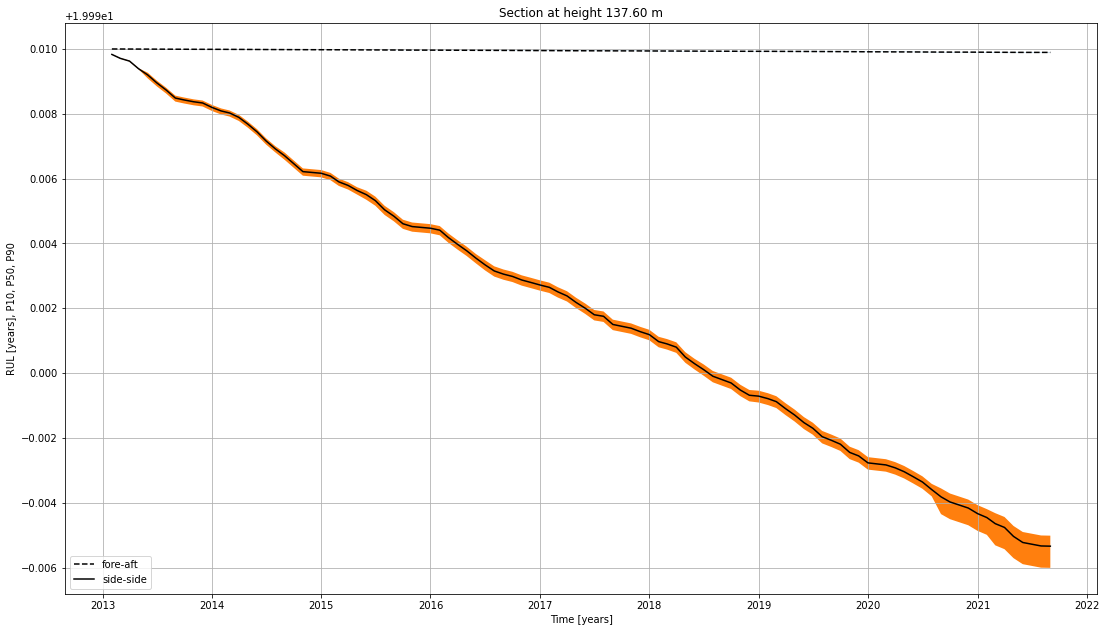

(1, Pos 10.000
H 127.790
t 12.500
A 1323.400
W 111086.000
DetailCategory 80.000
k_s 1.000
D_sigma_C 69.565
gamma_R 1.150
D_sigma_D 51.256
Name: 1, dtype: float64)
Evaluating for section at H = 127.79 m

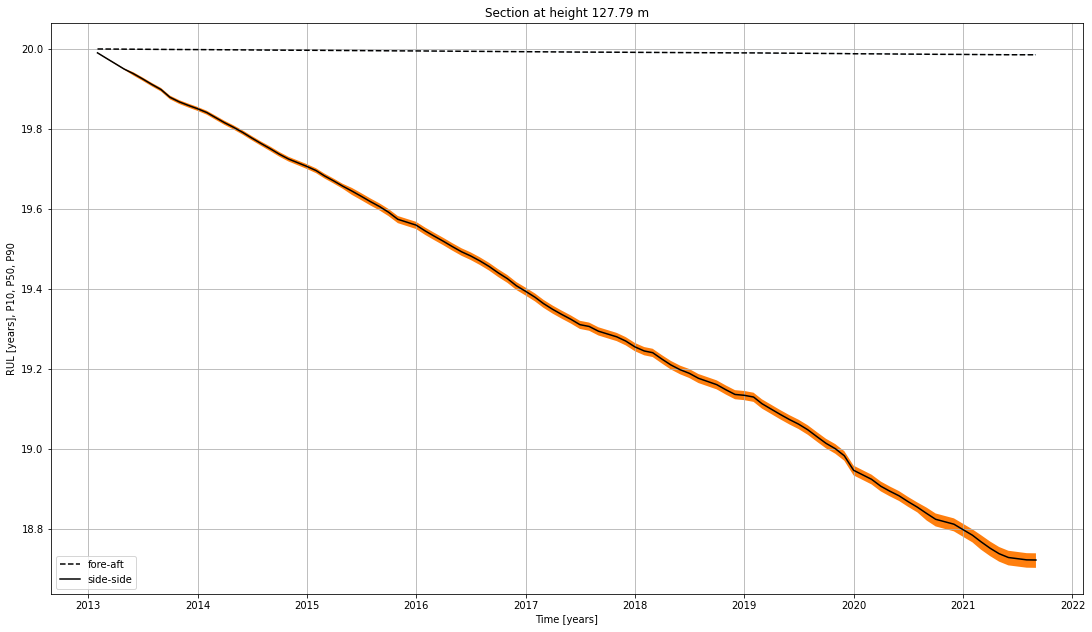

(2, Pos 20.000
H 113.440
t 14.300
A 1603.800
W 142572.000
DetailCategory 90.000
k_s 1.000
D_sigma_C 78.261
gamma_R 1.150
D_sigma_D 57.663
Name: 2, dtype: float64)
Evaluating for section at H = 113.44 m

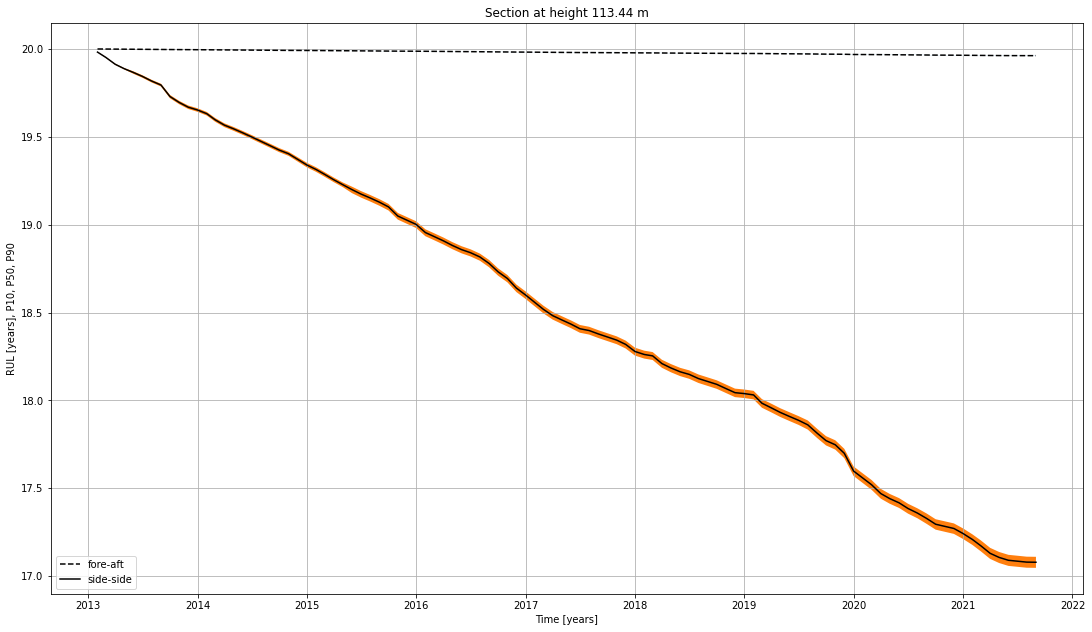

(3, Pos 30.000
H 104.890
t 16.500
A 1903.900
W 174052.000
DetailCategory 90.000
k_s 1.000
D_sigma_C 78.261
gamma_R 1.150
D_sigma_D 57.663
Name: 3, dtype: float64)
Evaluating for section at H = 104.89 m

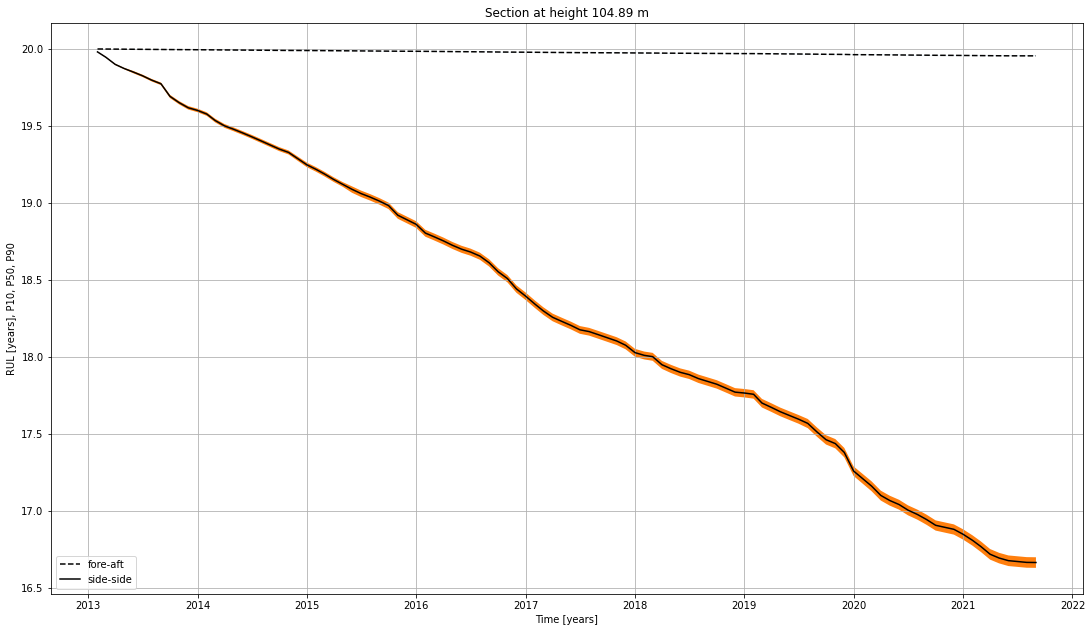

(4, Pos 40.000
H 90.440
t 20.500
A 2446.700
W 231131.000
DetailCategory 90.000
k_s 1.000
D_sigma_C 78.261
gamma_R 1.150
D_sigma_D 57.663
Name: 4, dtype: float64)
Evaluating for section at H = 90.44 m

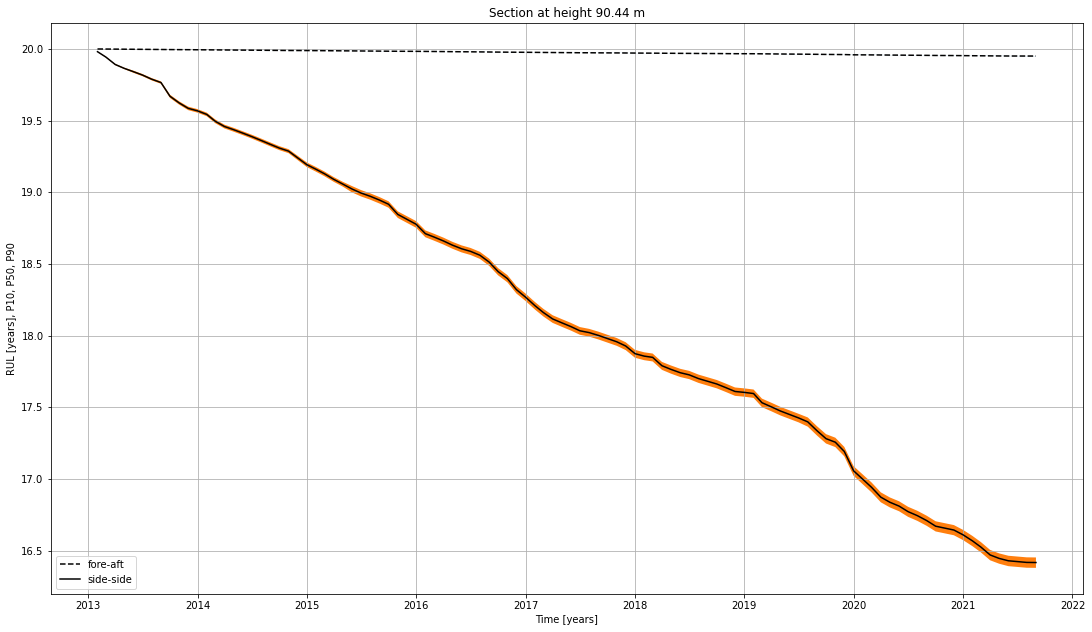

(5, Pos 50.000
H 78.760
t 23.600
A 2891.500
W 280238.000
DetailCategory 90.000
k_s 1.000
D_sigma_C 78.261
gamma_R 1.150
D_sigma_D 57.663
Name: 5, dtype: float64)
Evaluating for section at H = 78.76 m

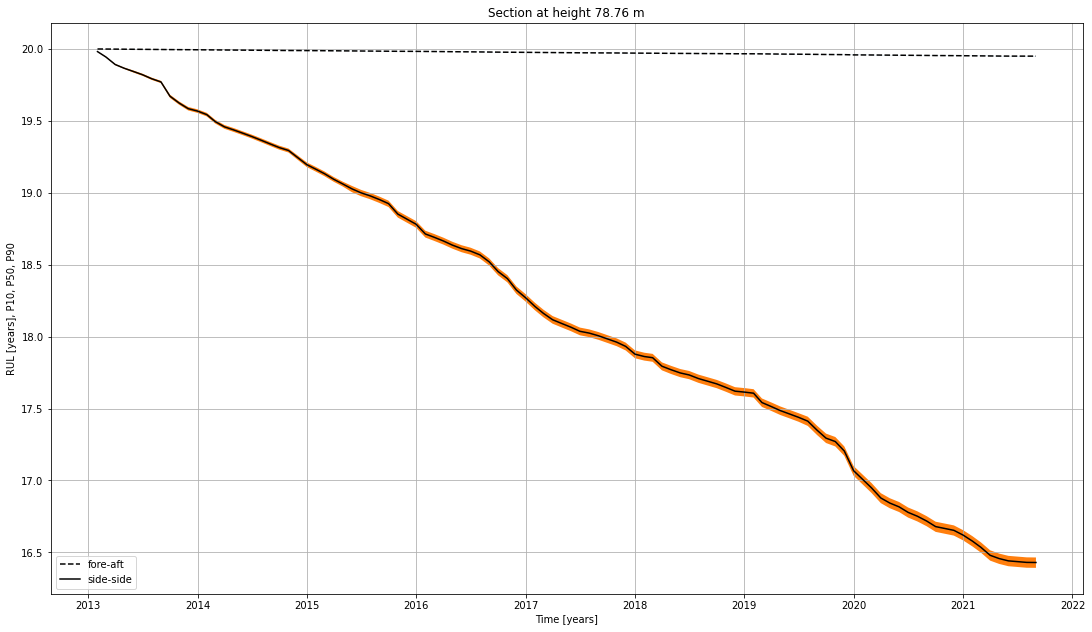

(6, Pos 60.0000
H 68.5000
t 25.8000
A 3235.6000
W 320857.0000
DetailCategory 90.0000
k_s 0.9937
D_sigma_C 77.7690
gamma_R 1.1500
D_sigma_D 57.3010
Name: 6, dtype: float64)
Evaluating for section at H = 68.50 m

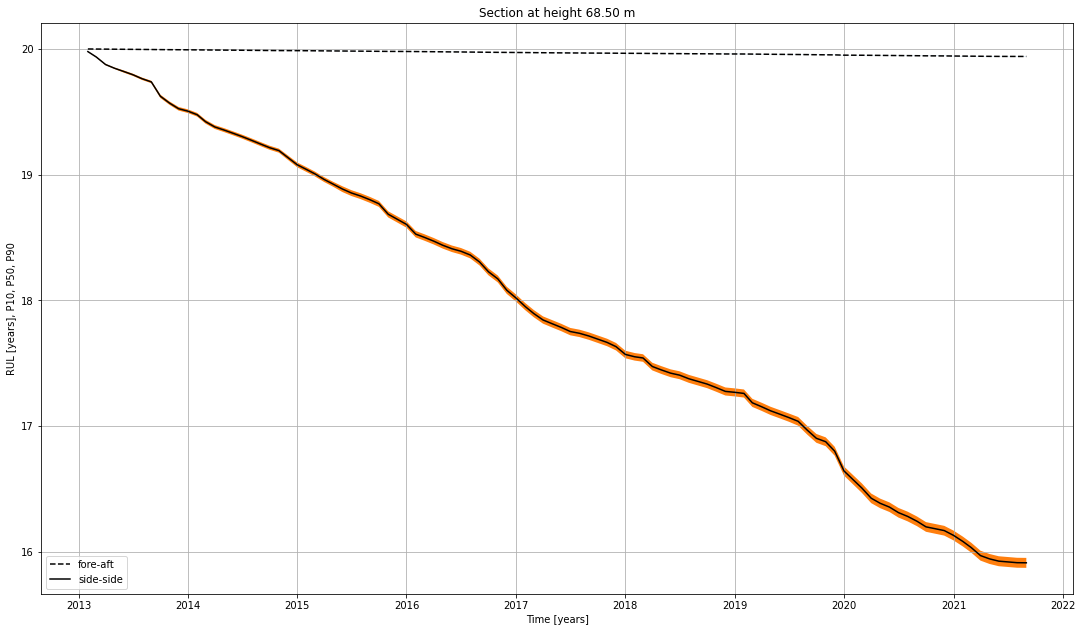

(7, Pos 70.0000
H 54.0800
t 28.8000
A 3731.3000
W 382049.0000
DetailCategory 90.0000
k_s 0.9721
D_sigma_C 76.0770
gamma_R 1.1500
D_sigma_D 56.0540
Name: 7, dtype: float64)
Evaluating for section at H = 54.08 m

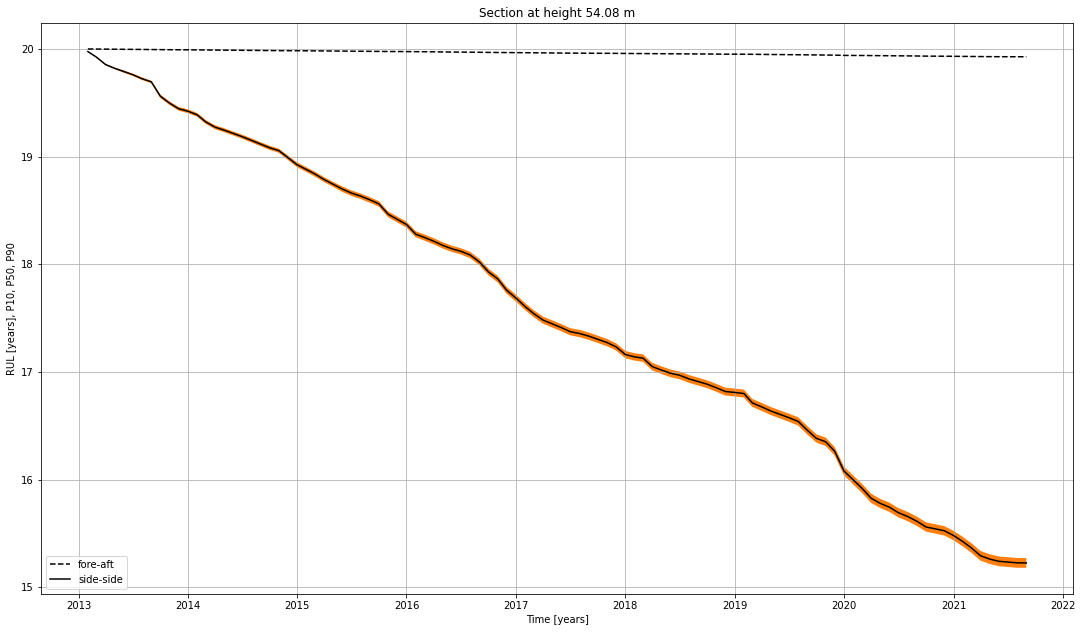

(8, Pos 80.0000
H 45.8100
t 31.0000
A 4041.7000
W 416236.0000
DetailCategory 90.0000
k_s 0.9579
D_sigma_C 74.9650
gamma_R 1.1500
D_sigma_D 55.2350
Name: 8, dtype: float64)
Evaluating for section at H = 45.81 m

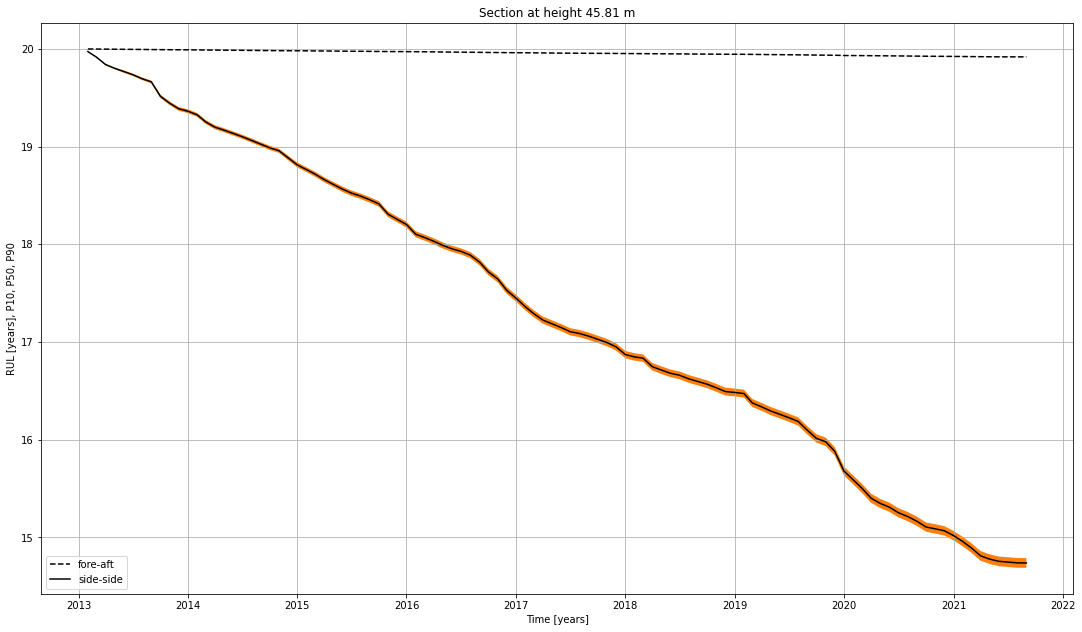

(9, Pos 90.0000
H 32.1600
t 37.2000
A 4850.0000
W 498756.0000
DetailCategory 90.0000
k_s 0.9236
D_sigma_C 72.2810
gamma_R 1.1500
D_sigma_D 53.2570
Name: 9, dtype: float64)
Evaluating for section at H = 32.16 m

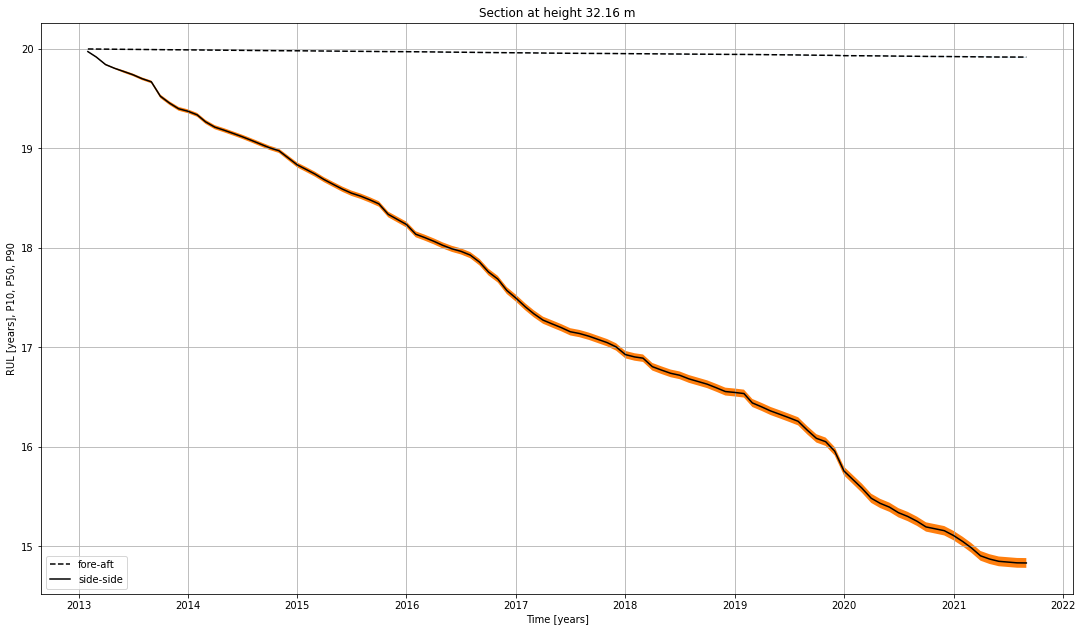

(10, Pos 100.0000
H 23.6100
t 42.7000
A 5567.1000
W 571761.0000
DetailCategory 90.0000
k_s 0.8985
D_sigma_C 70.3150
gamma_R 1.1500
D_sigma_D 51.8080
Name: 10, dtype: float64)
Evaluating for section at H = 23.61 m

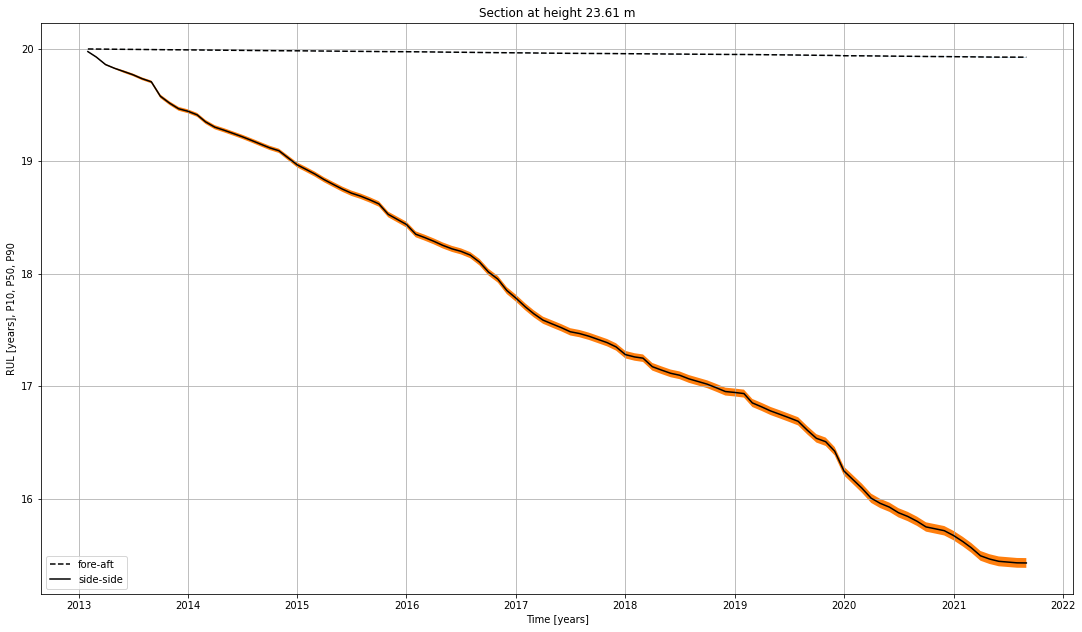

(11, Pos 110.0000
H 12.6800
t 51.0000
A 6649.2000
W 681581.0000
DetailCategory 90.0000
k_s 0.8671
D_sigma_C 67.8610
gamma_R 1.1500
D_sigma_D 50.0000
Name: 11, dtype: float64)
Evaluating for section at H = 12.68 m

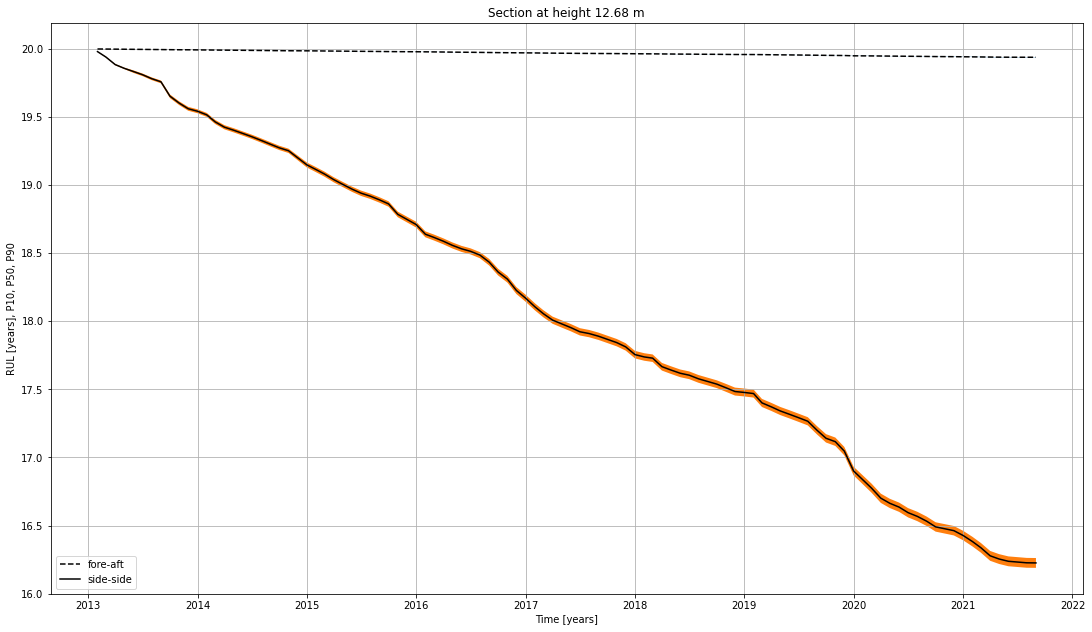

(12, Pos 120.0000
H 5.6900
t 62.0000
A 8083.3000
W 826484.0000
DetailCategory 90.0000
k_s 0.8339
D_sigma_C 65.2610
gamma_R 1.1500
D_sigma_D 48.0850
Name: 12, dtype: float64)
Evaluating for section at H = 5.69 m

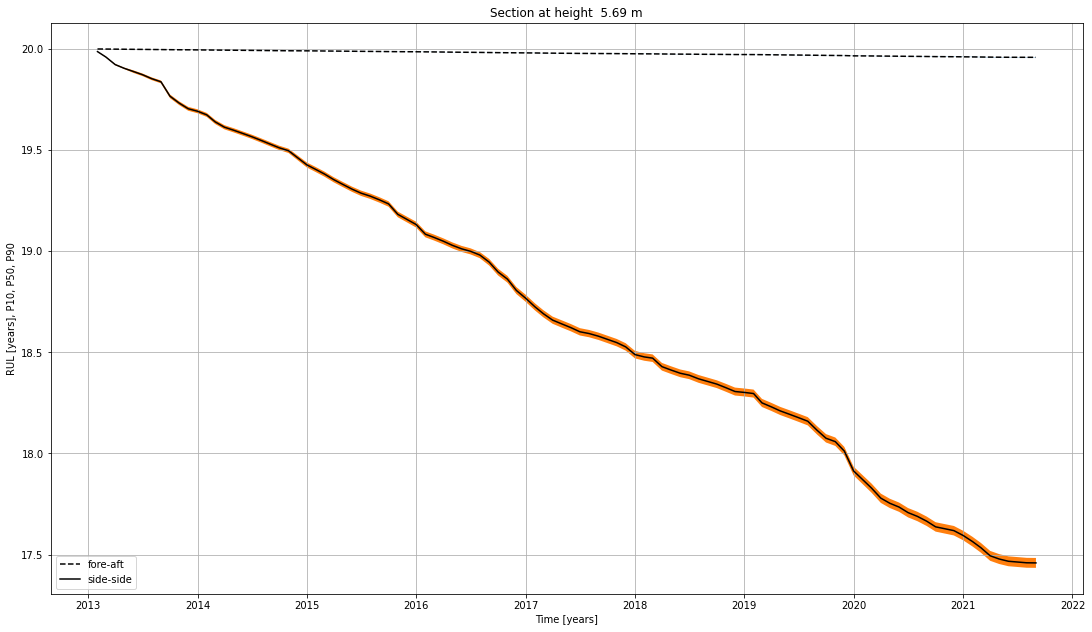

(13, Pos 126.0000
H 0.0000
t 62.0000
A 8083.3000
W 826484.0000
DetailCategory 90.0000
k_s 0.8339
D_sigma_C 65.2610
gamma_R 1.1500
D_sigma_D 48.0850
Name: 13, dtype: float64)
Evaluating for section at H = 0.00 m

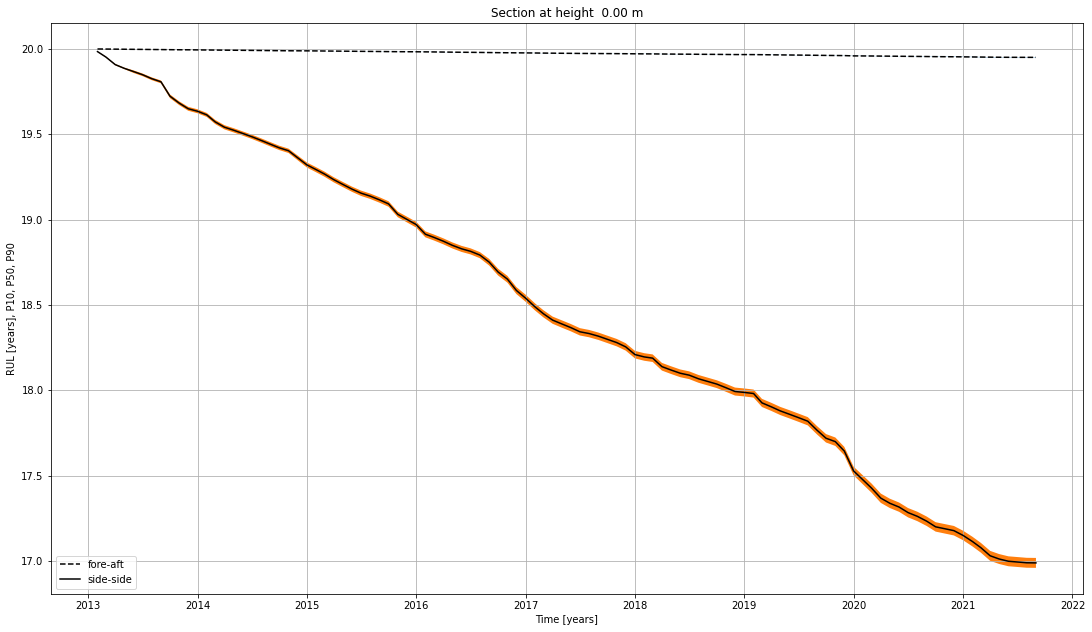

In [0]:
turbineId = dbutils.widgets.get('Turbine')

# Loop over the tower sections
RUL_results = []

df_predictions = spark.sql(f"select * from asset_life.predictions where TURBINE_SK_FK={turbineId}").toPandas()
df_predictions.sort_values(by='MONTH', inplace=True)
t = df_predictions['MONTH']
wtg_id = getArgument('Turbine')

for section in tower_section_data.iterrows():
  print(section)
  print('Evaluating for section at H = %5.2f m' % section[1].H)
  
  E_M_y, COV_M_y, E_M_z, COV_M_z = get_predicted_loads_at_height(df_predictions, H=section[1].H, meas_heights=meas_heights)
  # Parameters of lognormal distribution to be used for loads since they cannot be negative
  s_y = np.sqrt(np.log(COV_M_y**2 + 1))
  mu_y = np.log(E_M_y) - 0.5*s_y**2
  s_z = np.sqrt(np.log(COV_M_z**2 + 1))
  mu_z = np.log(E_M_z) - 0.5*s_z**2

  # now calculate damage
  consumed_life_samples_y = compute_consumed_life_section(section=section, num_chunks=len(E_M_y), mu=mu_y, s=s_y, num_mc_samples=num_mc_samples, rand_seed=rand_seed)
  consumed_life_samples_z = compute_consumed_life_section(section=section, num_chunks=len(E_M_z), mu=mu_z, s=s_z, num_mc_samples=num_mc_samples, rand_seed=rand_seed)

  # calculate RUL
  acc_consumed_life_y = np.quantile(np.cumsum(consumed_life_samples_y, axis=0), q=quantiles, axis=1)
  RUL_y = design_life - acc_consumed_life_y
  acc_consumed_life_z = np.quantile(np.cumsum(consumed_life_samples_z, axis=0), q=quantiles, axis=1)
  RUL_z = design_life - acc_consumed_life_z
    
  # store results
  # define data frame for results for section
  df_RUL = pd.DataFrame(index=t, data={'section_height': section[1].H, "month": df_predictions.MONTH.values, 'mean_y' : RUL_y[1, :], 'lwr_y' : RUL_y[2, :], 'upr_y' : RUL_y[0, :],
                                       'mean_z' : RUL_z[1, :], 'lwr_z' : RUL_z[2, :], 'upr_z' : RUL_z[0, :]})
  RUL_results.append(df_RUL)
  
  # plot burn down chart
  plt.plot(t, RUL_y[1, :], 'k--', label='fore-aft')
  plt.fill_between(t, RUL_y[0, :], RUL_y[2, :])
  plt.plot(t, RUL_z[1, :], 'k-', label='side-side')
  plt.fill_between(t, RUL_z[0, :], RUL_z[2, :])
  
  plt.gcf().set_size_inches(18.5, 10.5)
  plt.ylabel('RUL [years], P10, P50, P90')
  plt.xlabel('Time [years]')
  plt.legend()
  plt.grid()
  title_string = ('Section at height %5.2f m' % section[1].H)
  plt.title('Section at height %5.2f m' % section[1].H)
  plt.show()

In [0]:
#Concating all results
rulDf = pd.concat(RUL_results)

Calculation for the status of the turbine

In [0]:
%sql 
create or replace temporary view turbinedata as select ACTUAL_OPERATION_START_DATE 
from assetdata.v_site_turbine 
where SK_TURBINE_PK = getArgument("Turbine")

In [0]:
#Converting spark sql to pandas dataframe
turbinedf = spark.sql("select * from turbinedata").toPandas()

In [0]:
# Calculation of slope
import datetime
years = datetime.timedelta(days = 365) #defining years
date = datetime.date.today()#Taking todays date
turbinelife = (((date - turbinedf)/np.timedelta64(1,'Y')).to_numpy())[-1] #Calculating the life spent by turbine already after installation
slope = []
for x in rulDf['mean_z']: #Calculation slaope by taking consideration if Mean_Z RUl
  rul = x
  consumed_life = 20 - rul
  slope.append(consumed_life/turbinelife)
  
rulDf['slope'] = np.array(slope)

Calculation of estimated end of life

In [0]:
#curve fitting function to extrapolate the date
from scipy.optimize import curve_fit

#Linear function to calculate the co-efficents a&b from the trend
def linear(x,a,b):
  return (a*x + b)

#Loops on the towersection height to calculate the estimate the end of year and stores in the list
e_eoy = []
for x in tower_section_data.H:
  df = rulDf[rulDf['section_height'] == x]
  month_count = len(df.index) #Count of number of months predicted
  x_dummy = np.arange(0,month_count) #Created dummy array of months
  y_dummy = df['mean_z'].to_numpy() #created dummy array of RUL for months
  pars,cov = curve_fit(f=linear , xdata = x_dummy,ydata=y_dummy,p0=[0, 0], bounds=(-np.inf, np.inf)) #curve fit to find out co-efficients 'a' and 'b' from the trend 
  a,b = pars 
  remaining_months = b//-a
  e_eoy.append((remaining_months)//12)#Cobverting months to years

# Takes the min value from the list and adds to turbine operational start date which gives estimated end of life
estimated_EOL =pd.DataFrame(np.array(turbinedf +((min(e_eoy))*years)),columns=['estimated_EOL'])


In [0]:
#Converting dataframe with array to datetime object
estimated_EOL['estimated_EOL'] = estimated_EOL['estimated_EOL'].apply(pd.to_datetime)

In [0]:
#copying to the Dataframe which cantains all results
rulDf['estimated_EOL'] = ((estimated_EOL['estimated_EOL'])[0]).date()

In [0]:
sparkRulDF = spark.createDataFrame(rulDf) 

In [0]:
display(sparkRulDF)

section_height,month,mean_y,lwr_y,upr_y,mean_z,lwr_z,upr_z,slope,estimated_EOL
137.6,2013-02-01T00:10:00.000+0000,19.999999074942753,19.999999007977355,19.999999137742932,19.999830530304614,19.9998237890193,19.99983705115133,1.9336936962544124E-5,2043-01-25
137.6,2013-03-01T00:10:00.000+0000,19.99999812102395,19.999998011365758,19.999998222748573,19.99970993021092,19.999698390076613,19.999720663722247,3.309772412944894E-5,2043-01-25
137.6,2013-04-01T00:10:00.000+0000,19.99999689513166,19.99999666676236,19.999997097145858,19.9996245444576,19.999611823170923,19.99963654034052,4.2840462650773855E-5,2043-01-25
137.6,2013-05-01T00:10:00.000+0000,19.999995816031923,19.99999557047106,19.99999602761637,19.99938980447092,19.99937420799386,19.999404470342714,6.962491113100282E-5,2043-01-25
137.6,2013-06-01T00:10:00.000+0000,19.999994907725203,19.99999443292032,19.999995279539164,19.999195864013103,19.999089805243504,19.999265634149744,9.175402630246302E-5,2043-01-25
137.6,2013-07-01T00:10:00.000+0000,19.999993661772688,19.9999931848503,19.999994042942912,19.998953682893816,19.998847164109858,19.999023805330427,1.1938752753991777E-4,2043-01-25
137.6,2013-08-01T00:10:00.000+0000,19.999992544891466,19.9999920021191,19.999992995975504,19.998734680125686,19.998626831041943,19.998805687262706,1.4437631808623835E-4,2043-01-25
137.6,2013-09-01T00:10:00.000+0000,19.999991345090343,19.99999072540761,19.999991867960237,19.998484682952395,19.998375391470756,19.998559197192,1.72901651596385E-4,2043-01-25
137.6,2013-10-01T00:10:00.000+0000,19.999990182178244,19.999989547944875,19.999990722044178,19.998424766452516,19.998315978929025,19.998499819023362,1.7973828146424582E-4,2043-01-25
137.6,2013-11-01T00:10:00.000+0000,19.999989338528884,19.999988705833722,19.99998987779014,19.99837057892972,19.998261626277337,19.998445501688536,1.8592122001307498E-4,2043-01-25


In [0]:
viewName = f'rul_{dbutils.widgets.get("Turbine")}'

sparkRulDF.createOrReplaceGlobalTempView(viewName)

dbutils.notebook.exit(viewName)

rul_4704